In [2]:
%matplotlib inline
import pandas as pd

In [3]:
purchases = pd.read_csv("../data/treated/purchases_enriched.csv")

## Trying a supervised model

In [8]:
data = purchases.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [9]:
data.head()

,Unnamed: 0,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,ANO,BENEFICIARIO_SALES,HAS_LINKEDIN
0,0,110152,161,167,1388,130,780,1,1019110.0,8,14911.80,2,11,12,2020,13,True
1,1,110152,161,167,1389,135,845,1,1019110.0,8,2528.80,2,11,12,2020,13,True
2,2,110152,161,167,1390,132,759,1,1019110.0,8,8500.02,2,11,12,2020,13,True
3,3,110152,161,167,1391,131,757,1,1019110.0,8,2400.01,2,11,12,2020,13,True
4,4,110152,161,167,1392,417,859,1,299001496.0,16,1537.00,2,23,12,2020,13,True


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [11]:
y = data.pop("IMPORTE")
X = data.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [12]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [14]:
r2_score(y_test, clf.predict(X_test))

0.18516692764281806

## Testing non-supervised model or clustering for the text

In [15]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [19]:
# Convert the data into tokens
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words("spanish") and len(token)>4:
            result.append(token)

    return result

In [18]:
process_business = [preprocess(x) for x in list(purchases["BENEFICIARIO"].unique())]

In [20]:
dictionary = gensim.corpora.Dictionary(process_business)

In [21]:
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [22]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]

In [23]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6,id2word=dictionary, passes = 10, workers=2)

In [24]:
for idx, type_business in lda_model.print_topics(-1):
    print("topic: {} Words: {}".format(idx, type_business))

topic: 0 Words: 0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"
topic: 1 Words: 0.033*"GARCIA" + 0.021*"GONZALEZ" + 0.021*"GARZA" + 0.018*"MARIA" + 0.013*"TREVIÑO" + 0.013*"SANCHEZ" + 0.013*"MARCELO" + 0.013*"ARTURO" + 0.013*"MANUEL" + 0.009*"ALBERTO"
topic: 2 Words: 0.015*"GRUPO" + 0.010*"SERVICIOS" + 0.010*"ESTHER" + 0.010*"MARTINEZ" + 0.010*"MONTERREY" + 0.010*"CONSTRUCTORA" + 0.010*"MORENO" + 0.005*"ALEJANDRO" + 0.005*"VILLARREAL" + 0.005*"HERNANDEZ"
topic: 3 Words: 0.026*"MARIA" + 0.023*"RODRIGUEZ" + 0.019*"GONZALEZ" + 0.018*"GOMEZ" + 0.012*"LOZANO" + 0.008*"TORRES" + 0.008*"DESARROLLO" + 0.008*"PEREZ" + 0.008*"SEGURIDAD" + 0.008*"SANCHEZ"
topic: 4 Words: 0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.010*"SEGUROS" + 0.010*"INTEGRACION" + 0.010*"SEBASTIAN," + 0.010*"ARRENDADORA" + 0.010*"GRU

In [25]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [28]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(purchases["BENEFICIARIO"].unique()))}

In [30]:
purchases["CLUSTER_NAME"] = purchases["BENEFICIARIO"].apply(lambda x: business_cluster[x])

<AxesSubplot:xlabel='CLUSTER_NAME'>

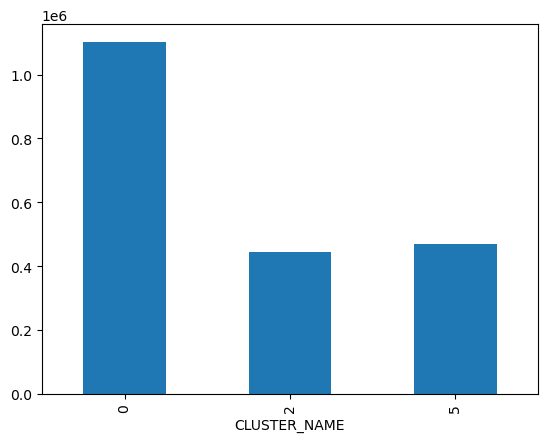

In [31]:
purchases.groupby("CLUSTER_NAME")["IMPORTE"].mean().plot.bar()